In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import akshare as ak
import datetime
from datetime import date, timedelta
import seaborn as sns
import time
import random
import itertools

from fund_tools import *

In [2]:
# Set date variable

today = date.today()
first_day_of_the_week = today - timedelta(days=today.weekday())
# end = start + timedelta(days=6)
print("Today: " + str(today))
print("Start: " + str(first_day_of_the_week))
# print("End: " + str(end))

Today: 2021-10-02
Start: 2021-09-27


In [3]:
start_date = '2015-01-01'
end_date = '2021-09-30'

fund_net_value = get_fund_net_worth('001980',start_date=start_date, end_date=end_date, fund_category='open')
fund_net_value

,净值日期,单位净值,日增长率
0,2018-05-16,1.0000,0.00
1,2018-05-18,1.0002,0.00
2,2018-05-25,1.0003,0.00
3,2018-06-01,0.9999,0.00
4,2018-06-08,1.0008,0.00
...,...,...,...
807,2021-09-24,1.9603,-1.39
808,2021-09-27,1.9263,-1.73
809,2021-09-28,1.9249,-0.07
810,2021-09-29,1.8725,-2.72


In [4]:
AIP_weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, freq='Monday', df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,001980,1194,Monday,1000,158.0,138466.734,1.141,106596.083,0.675,0.171


In [58]:
def AIP_Weekly(code, start_date, end_date, fund_category, fixed_investment, freq='Monday', df=False, AIP=True, Total_investment=100000):
    
    
    fund_net_value = get_fund_net_worth(code, start_date=start_date, end_date=end_date, fund_category=fund_category)
    
    fund_net_value['WeekDay'] = pd.to_datetime(fund_net_value['净值日期']).dt.day_name()
    
    
    if AIP:
        fund_net_value['定投金额(本金)'] = 0
            
        for i in range(len(fund_net_value['WeekDay'])):
             if fund_net_value['WeekDay'].values[i] == freq:
                    fund_net_value['定投金额(本金)'][i] = fixed_investment
                
        fund_net_value['累计定投金额(本金)'] = fund_net_value['定投金额(本金)'].cumsum()
        fund_net_value['购买份额'] = fund_net_value['定投金额(本金)']/fund_net_value['单位净值']
        fund_net_value['累计份额'] = fund_net_value['购买份额'].cumsum()
        fund_net_value['平均成本'] = fund_net_value['累计定投金额(本金)']/fund_net_value['累计份额']
    
        fund_net_value['累计收益'] = (fund_net_value['单位净值'] - fund_net_value['平均成本']) * fund_net_value['累计份额']
        
        start_invest = fund_net_value['定投金额(本金)'].values.nonzero()[0][0]
        fund_net_value['持有天数(定投)'] = (fund_net_value['净值日期'] - fund_net_value['净值日期'][start_invest]).dt.days+1
        for i in range(len(fund_net_value['持有天数(定投)'])):
            if fund_net_value['持有天数(定投)'][i] < 0:
                fund_net_value['持有天数(定投)'][i] = 0
        fund_net_value['年化收益率'] = ((fund_net_value['累计收益'] + fund_net_value['累计定投金额(本金)'])/fund_net_value['累计定投金额(本金)'])**(365/fund_net_value['持有天数(定投)'])-1
        fund_net_value['累计收益率'] = fund_net_value['累计收益']/fund_net_value['累计定投金额(本金)']
        
        Stat_df = pd.DataFrame({
                '基金代码': code,
                '持有天数': fund_net_value['持有天数(定投)'].values[-1],
                '定投时间': freq,
                '定投金额': fixed_investment,
                '分投期数': fund_net_value['累计定投金额(本金)'].values[-1]/fixed_investment,
                '总购买份额' : '%.3f' % fund_net_value['累计份额'].values[-1],
                '平均成本' : '%.3f' % fund_net_value['平均成本'].values[-1],
                '累计收益' : '%.3f' % fund_net_value['累计收益'].values[-1],
                '累计收益率' : '%.3f' % fund_net_value['累计收益率'].values[-1],
                '年化收益率' : '%.3f' % fund_net_value['年化收益率'].values[-1]
            }, index=['AIP'])
    
    else:
        fund_net_value['直投金额(本金)'] = 0
        fund_net_value['直投金额(本金)'][0] = Total_investment
        fund_net_value['直投累计购买份额(不变)'] = fund_net_value['直投金额(本金)'][0]/ fund_net_value['单位净值'][0]
        fund_net_value['直投累计收益'] = (fund_net_value['单位净值'] - fund_net_value['单位净值'][0]) * fund_net_value['直投金额(本金)'][0]
        fund_net_value['直投累计收益率'] = fund_net_value['直投累计收益']/fund_net_value['直投累计购买份额(不变)']
        fund_net_value['持有天数(直投)'] = (fund_net_value['净值日期'] - fund_net_value['净值日期'][0]).dt.days+1
        fund_net_value['直投累计年化收益率'] = ((fund_net_value['直投金额(本金)'][0] + fund_net_value['直投累计收益'])/fund_net_value['直投金额(本金)'][0])**(365/fund_net_value['持有天数(直投)'])-1
    
    
        Stat_df = pd.DataFrame({
            '基金代码': code,
            '持有天数': fund_net_value['持有天数(直投)'].values[-1],
            '总购买份额' : '%.3f' % fund_net_value['直投累计购买份额(不变)'].values[0],
            '累计收益' : '%.3f' % fund_net_value['直投累计收益'].values[-1],
            '累计收益率' : '%.3f' % fund_net_value['直投累计收益率'].values[-1],
            '年化收益率' : '%.3f' % fund_net_value['直投累计年化收益率'].values[-1]
        }, index=['DIP'])
    
    if df:
        return fund_net_value
    else:
        return Stat_df

In [17]:
AIP_direct_df = AIP_weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, freq='Monday', AIP=False, df=False)
AIP_direct_df

,基金代码,持有天数,总购买份额,累计收益,累计收益率,年化收益率
DIP,001980,1234,100000.000,91090.000,0.911,0.211


In [9]:
AIP_df = AIP_weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, freq='Monday', AIP=True, df=True)
AIP_df

,净值日期,单位净值,日增长率,WeekDay,定投金额(本金),累计定投金额(本金),购买份额,累计份额,平均成本,累计收益,持有天数(定投),年化收益率,累计收益率
0,2018-05-16,1.0000,0.00,Wednesday,0,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN
1,2018-05-18,1.0002,0.00,Friday,0,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN
2,2018-05-25,1.0003,0.00,Friday,0,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN
3,2018-06-01,0.9999,0.00,Friday,0,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN
4,2018-06-08,1.0008,0.00,Friday,0,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,2021-09-24,1.9603,-1.39,Friday,0,157000,0.000000,137947.604561,1.138113,113418.689220,1188,0.181818,0.722412
808,2021-09-27,1.9263,-1.73,Monday,1000,158000,519.129938,138466.734499,1.141068,108728.470665,1191,0.174070,0.688155
809,2021-09-28,1.9249,-0.07,Tuesday,0,158000,0.000000,138466.734499,1.141068,108534.617237,1192,0.173651,0.686928
810,2021-09-29,1.8725,-2.72,Wednesday,0,158000,0.000000,138466.734499,1.141068,101278.960349,1193,0.163626,0.641006


In [7]:
Freq = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

AIP_Weekly_Plans(Freq, '001980', start_date, end_date, fund_category='open', fixed_investment=1000, AIP=True, df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,001980,1194,Monday,1000,158.0,138466.734,1.141,106596.083,0.675,0.171
AIP,001980,1200,Tuesday,1000,162.0,141338.483,1.146,108083.707,0.667,0.168
AIP,001980,1234,Wednesday,1000,164.0,143250.605,1.145,109737.582,0.669,0.164
AIP,001980,1205,Thursday,1000,164.0,143136.130,1.146,109518.831,0.668,0.168
AIP,001980,1232,Friday,1000,162.0,141864.343,1.142,109088.573,0.673,0.165


In [23]:
def AIP_Weekly_plot(code, start_date, end_date, fund_category, fixed_investment=1000, Freq=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], figsize=(12,8)):
    
    fig,ax = plt.subplots(figsize=figsize)
    
    for freq in Freq:
        AIP_df = AIP_weekly(code, start_date=start_date, end_date=end_date, fund_category=fund_category, fixed_investment=fixed_investment, freq=freq, AIP=True, df=True)
    
        ax.plot(AIP_df.净值日期, AIP_df.累计收益率, label=freq)
        ax.legend()
    ax.set_xlabel("净值日期", fontsize=14)
    ax.set_ylabel("定投累计收益", fontsize=14)

    AIP_direct_df = AIP_weekly(code, start_date=start_date, end_date=end_date, fund_category=fund_category, fixed_investment=1000, freq='Monday', AIP=False, df=True)
    ax2=ax.twinx()
    ax2.plot(AIP_df.净值日期, AIP_direct_df["直投累计收益率"], '--', label='直投累计收益率')
    ax2.legend(loc='upper right')
    ax2.set_ylabel("直投累计收益率",fontsize=14)
    plt.show()

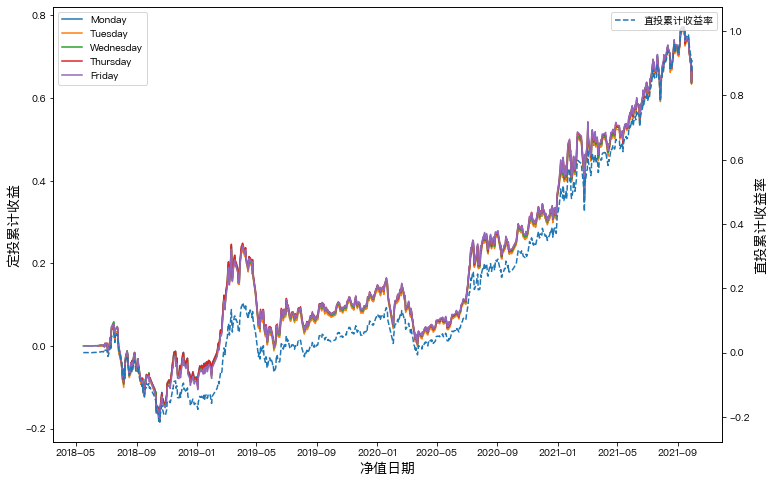

In [24]:
AIP_Weekly_plot('001980', start_date, end_date, 'open')

In [28]:
def Max_AIP_Weekly(code, start_date, end_date, fund_category, fixed_investment, Threshold=(-3.0, 2.0), AIP=True, df=False, Total_investment=100000):
    
    fund_net_value = get_fund_net_worth(code, start_date=start_date, end_date=end_date, fund_category=fund_category)
    
    fund_net_value['WeekDay'] = pd.to_datetime(fund_net_value['净值日期']).dt.day_name()
    
    if AIP:
        fund_net_value['定投金额(本金)'] = 0
        fund_net_value['累计定投金额(本金)'] = fund_net_value['定投金额(本金)'].cumsum()
            
        for i in range(len(fund_net_value['日增长率'])):
            if fund_net_value['日增长率'].values[i] <= Threshold[0]:
                fund_net_value['定投金额(本金)'][i] = fixed_investment
                fund_net_value['累计定投金额(本金)'] = fund_net_value['定投金额(本金)'].cumsum()
            elif (fund_net_value['日增长率'].values[i] >= Threshold[1]) & (fund_net_value['累计定投金额(本金)'].values[i-1] > fixed_investment):
                fund_net_value['定投金额(本金)'][i] = -fixed_investment
                fund_net_value['累计定投金额(本金)'] = fund_net_value['定投金额(本金)'].cumsum()
    
        fund_net_value['购买份额'] = fund_net_value['定投金额(本金)']/fund_net_value['单位净值']
        fund_net_value['累计份额'] = fund_net_value['购买份额'].cumsum()
        fund_net_value['平均成本'] = fund_net_value['累计定投金额(本金)']/fund_net_value['累计份额']
    
        fund_net_value['累计收益'] = (fund_net_value['单位净值'] - fund_net_value['平均成本']) * fund_net_value['累计份额']
        
        start_invest = fund_net_value['定投金额(本金)'].values.nonzero()[0][0]
        fund_net_value['持有天数'] = (fund_net_value['净值日期'] - fund_net_value['净值日期'][start_invest]).dt.days+1
        for i in range(len(fund_net_value['持有天数'])):
            if fund_net_value['持有天数'][i] < 0:
                fund_net_value['持有天数'][i] = 0
        fund_net_value['年化收益率'] = ((fund_net_value['累计收益'] + fund_net_value['累计定投金额(本金)'])/fund_net_value['累计定投金额(本金)'])**(365/fund_net_value['持有天数'])-1
    
        fund_net_value['累计收益率'] = fund_net_value['累计收益']/fund_net_value['累计定投金额(本金)']
        
        Stat_df = pd.DataFrame({
            '基金代码': code,
            '持有天数': fund_net_value['持有天数'].values[-1],
            '触发投资门槛(低买入)': Threshold[0],
            '触发投资门槛(高卖出)': Threshold[1],
            '单次金额': fixed_investment,
            '买入次数': len(fund_net_value[fund_net_value['定投金额(本金)'] == 1000]),
            '卖出次数': len(fund_net_value[fund_net_value['定投金额(本金)'] == -1000]),
            '总购买份额' : '%.3f' % fund_net_value['累计份额'].values[-1],
            '平均成本' : '%.3f' % fund_net_value['平均成本'].values[-1],
            '累计收益' : '%.3f' % fund_net_value['累计收益'].values[-1],
            '累计收益率' : '%.3f' % fund_net_value['累计收益率'].values[-1],
            '年化收益率' : '%.3f' % fund_net_value['年化收益率'].values[-1]
        }, index=['Plan'])
        
    else:
        
        fund_net_value['直投金额(本金)'] = 0
        fund_net_value['直投金额(本金)'][0] = Total_investment
        fund_net_value['直投累计购买份额(不变)'] = fund_net_value['直投金额(本金)'][0]/ fund_net_value['单位净值'][0]
        fund_net_value['直投累计收益'] = (fund_net_value['单位净值'] - fund_net_value['单位净值'][0]) * fund_net_value['直投金额(本金)'][0]
        fund_net_value['直投累计收益率'] = fund_net_value['直投累计收益']/fund_net_value['直投累计购买份额(不变)']
        fund_net_value['持有天数(直投)'] = (fund_net_value['净值日期'] - fund_net_value['净值日期'][0]).dt.days+1
        fund_net_value['直投累计年化收益率'] = ((fund_net_value['直投金额(本金)'][0] + fund_net_value['直投累计收益'])/fund_net_value['直投金额(本金)'][0])**(365/fund_net_value['持有天数(直投)'])-1
    
    
        Stat_df = pd.DataFrame({
            '基金代码': code,
            '持有天数': fund_net_value['持有天数(直投)'].values[-1],
            '总购买份额' : '%.3f' % fund_net_value['直投累计购买份额(不变)'].values[0],
            '累计收益' : '%.3f' % fund_net_value['直投累计收益'].values[-1],
            '累计收益率' : '%.3f' % fund_net_value['直投累计收益率'].values[-1],
            '年化收益率' : '%.3f' % fund_net_value['直投累计年化收益率'].values[-1]
        }, index=['DIP'])
    
    if df:
        return fund_net_value
    else:
        return Stat_df

In [29]:
Max_AIP_Weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, AIP=True, df=False)

,基金代码,持有天数,触发投资门槛(低买入),触发投资门槛(高卖出),单次金额,买入次数,卖出次数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
Plan,001980,1089,-3.0,2.0,1000,12,11,1368.136,0.731,1614.371,1.614,0.380


In [30]:
Max_AIP_Weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, AIP=False, df=False)

,基金代码,持有天数,总购买份额,累计收益,累计收益率,年化收益率
DIP,001980,1234,100000.000,91090.000,0.911,0.211


In [36]:
for plan in max_plan:
    print(max_plan[plan])

(-3.0, 1.0)


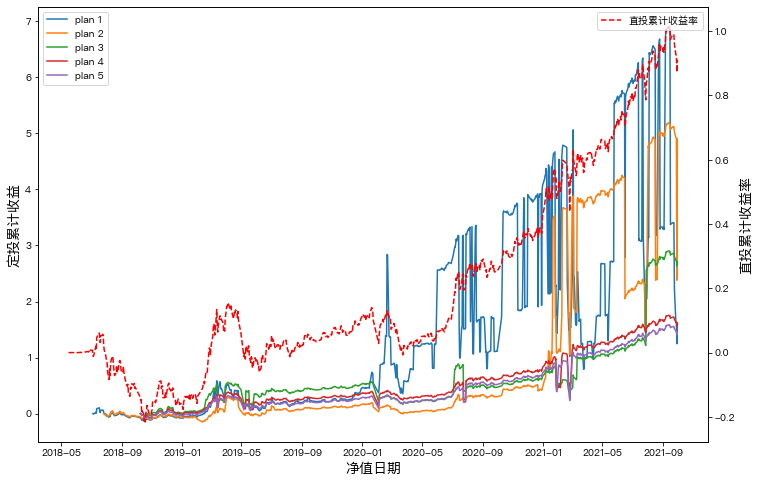

In [45]:
max_plan = {
    'plan 1': (-1.0, 1.0),
    'plan 2': (-2.0, 2.0),
    'plan 3': (-3.0, 3.0),
    'plan 4': (-3.0, 2.0),
    'plan 5': (-3.0, 1.0),
}

def AIP_Weekly_plot(code, start_date, end_date, fund_category, fixed_investment=1000, max_plan=max_plan, figsize=(12,8)):
    
    fig,ax = plt.subplots(figsize=figsize)
    
    for plan in max_plan:
        Max_AIP_df = Max_AIP_Weekly(code, start_date=start_date, end_date=end_date, fund_category=fund_category, fixed_investment=fixed_investment, 
                                    Threshold=max_plan[plan], AIP=True, df=True)
    
        ax.plot(Max_AIP_df.净值日期, Max_AIP_df.累计收益率, label=plan)
        ax.legend()
    ax.set_xlabel("净值日期", fontsize=14)
    ax.set_ylabel("定投累计收益", fontsize=14)

    Max_AIP_direct_df = Max_AIP_Weekly(code, start_date=start_date, end_date=end_date, fund_category=fund_category, fixed_investment=1000, AIP=False, df=True)
    ax2=ax.twinx()
    ax2.plot(Max_AIP_direct_df.净值日期, Max_AIP_direct_df["直投累计收益率"], 'r--', label='直投累计收益率')
    ax2.legend(loc='upper right')
    ax2.set_ylabel("直投累计收益率",fontsize=14)
    plt.show()
    
AIP_Weekly_plot('001980', start_date, end_date, 'open')

In [50]:
df = Max_AIP_weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, df=True)
df

,净值日期,单位净值,日增长率,WeekDay,定投金额(本金),累计定投金额(本金),购买份额,累计份额,平均成本,累计收益,持有天数,年化收益率,累计收益率
0,2018-05-16,1.0000,0.00,Wednesday,0,0,0.0,0.000000,NaN,NaN,0,NaN,NaN
1,2018-05-18,1.0002,0.00,Friday,0,0,0.0,0.000000,NaN,NaN,0,NaN,NaN
2,2018-05-25,1.0003,0.00,Friday,0,0,0.0,0.000000,NaN,NaN,0,NaN,NaN
3,2018-06-01,0.9999,0.00,Friday,0,0,0.0,0.000000,NaN,NaN,0,NaN,NaN
4,2018-06-08,1.0008,0.00,Friday,0,0,0.0,0.000000,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,2021-09-24,1.9603,-1.39,Friday,0,1000,0.0,1368.136167,0.730921,1681.957327,1083,0.394440,1.681957
808,2021-09-27,1.9263,-1.73,Monday,0,1000,0.0,1368.136167,0.730921,1635.440698,1086,0.384991,1.635441
809,2021-09-28,1.9249,-0.07,Tuesday,0,1000,0.0,1368.136167,0.730921,1633.525307,1087,0.384238,1.633525
810,2021-09-29,1.8725,-2.72,Wednesday,0,1000,0.0,1368.136167,0.730921,1561.834972,1088,0.371071,1.561835


In [51]:
def Max_AIP_Weekly_Plans(code, start_date, end_date, fund_category, fixed_investment, upper_threshold, lower_threshold):
    
    df = pd.DataFrame()
    threshold_list = list(itertools.product(lower_threshold, upper_threshold))
    for i in range(len(threshold_list)):

        df = df.append(Max_AIP_weekly(code, start_date=start_date, end_date=end_date, fund_category=fund_category, fixed_investment=fixed_investment, 
                       Threshold=threshold_list[i], df=False))
        
    return df

In [52]:
upper_threshold = [1.0, 2.0, 3.0, 4.0, 5.0]
lower_threshold = [-1.0, -2.0, -3.0, -4.0, -5.0]

Max_AIP_Weekly_Plans('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, 
                     upper_threshold=upper_threshold, lower_threshold=lower_threshold)

,基金代码,持有天数,触发投资门槛(低买入),触发投资门槛(高卖出),单次金额,买入次数,卖出次数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
Plan,001980,1185,-1.0,1.0,1000,130,126,5472.049,0.731,6456.538,1.614,0.344
Plan,001980,1185,-1.0,2.0,1000,130,51,73530.342,1.074,61509.130,0.779,0.194
Plan,001980,1185,-1.0,3.0,1000,130,20,100104.242,1.099,81289.196,0.739,0.186
Plan,001980,1185,-1.0,4.0,1000,130,4,115089.750,1.095,93925.003,0.745,0.187
Plan,001980,1185,-1.0,5.0,1000,130,2,117055.368,1.093,95681.102,0.748,0.188
Plan,001980,1163,-2.0,1.0,1000,43,42,1250.628,0.800,1389.825,1.390,0.314
Plan,001980,1163,-2.0,2.0,1000,43,42,3086.672,0.324,4898.321,4.898,0.745
Plan,001980,1163,-2.0,3.0,1000,43,19,22250.803,1.079,18519.060,0.772,0.197
Plan,001980,1163,-2.0,4.0,1000,43,4,36281.475,1.075,30330.270,0.778,0.198
Plan,001980,1163,-2.0,5.0,1000,43,2,38247.093,1.072,32086.370,0.783,0.199


In [376]:
StochasticAIP_Weekly('001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, Freq=5, seed=12345, df=True)


,净值日期,单位净值,日增长率,WeekDay,定投金额(本金),累计定投金额(本金),购买份额,累计份额,平均成本,累计收益,持有天数,年化收益率,累计收益率
0,2018-05-16,1.0000,0.00,Wednesday,1000,1000,1000.0,1000.000000,1.000000,0.000000,1,0.000000,0.000000
1,2018-05-18,1.0002,0.00,Friday,0,1000,0.0,1000.000000,1.000000,0.200000,3,0.024629,0.000200
2,2018-05-25,1.0003,0.00,Friday,0,1000,0.0,1000.000000,1.000000,0.300000,10,0.011009,0.000300
3,2018-06-01,0.9999,0.00,Friday,0,1000,0.0,1000.000000,1.000000,-0.100000,17,-0.002145,-0.000100
4,2018-06-08,1.0008,0.00,Friday,0,1000,0.0,1000.000000,1.000000,0.800000,24,0.012236,0.000800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,2021-09-24,1.9603,-1.39,Friday,0,170000,0.0,149218.943529,1.139266,122513.895000,1228,0.175051,0.720670
808,2021-09-27,1.9263,-1.73,Monday,0,170000,0.0,149218.943529,1.139266,117440.450920,1231,0.168511,0.690826
809,2021-09-28,1.9249,-0.07,Tuesday,0,170000,0.0,149218.943529,1.139266,117231.544399,1232,0.168112,0.689597
810,2021-09-29,1.8725,-2.72,Wednesday,0,170000,0.0,149218.943529,1.139266,109412.471758,1233,0.158461,0.643603


In [381]:
Freq = 5
seed = [1234, 123, 2133, 2314, 435]

StochasticAIP_Weekly_Plans(Freq=Freq, seed=seed, code='001980', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
Plan,001980,1234,随机,1000,166.0,145656.839,1.140,112335.654,0.677,0.165
Plan,001980,1232,随机,1000,171.0,149798.443,1.142,115249.844,0.674,0.165
Plan,001980,1232,随机,1000,170.0,149572.854,1.137,115818.767,0.681,0.166
Plan,001980,1232,随机,1000,168.0,147792.038,1.137,114415.806,0.681,0.166
Plan,001980,1232,随机,1000,172.0,151100.228,1.138,116737.425,0.679,0.166


In [380]:
Freq = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

AIP_Weekly_Plans(Freq, '001980', start_date, end_date, fund_category='open', fixed_investment=1000, df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
Plan,001980,1194,Monday,1000,158.0,138466.734,1.141,106596.083,0.675,0.171
Plan,001980,1200,Tuesday,1000,162.0,141338.483,1.146,108083.707,0.667,0.168
Plan,001980,1234,Wednesday,1000,164.0,143250.605,1.145,109737.582,0.669,0.164
Plan,001980,1205,Thursday,1000,164.0,143136.130,1.146,109518.831,0.668,0.168
Plan,001980,1232,Friday,1000,162.0,141864.343,1.142,109088.573,0.673,0.165


In [53]:
AIP_weekly('004854', start_date=start_date, end_date=end_date, fund_category='open', fixed_investment=1000, freq='Monday', df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,004854,1523,Monday,1000,196.0,218175.726,0.898,134143.509,0.684,0.133


In [55]:
def AIP_Weekly_Plans(Freq, code, start_date, end_date, fund_category, fixed_investment, AIP=True, df=False):
    
    df = pd.DataFrame()
    
    for freq in Freq:
        df = df.append(AIP_Weekly(code, start_date=start_date, end_date=end_date, fund_category=fund_category, fixed_investment=fixed_investment, freq=freq, AIP=True, df=False))
        
    return df

In [59]:
Freq=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

AIP_Weekly_Plans(Freq, '004854', start_date, end_date, fund_category='open', fixed_investment=1000, AIP=True, df=False)

,基金代码,持有天数,定投时间,定投金额,分投期数,总购买份额,平均成本,累计收益,累计收益率,年化收益率
AIP,004854,1523,Monday,1000,196.0,218175.726,0.898,134143.509,0.684,0.133
AIP,004854,1487,Tuesday,1000,200.0,221677.315,0.902,135442.113,0.677,0.135
AIP,004854,1493,Wednesday,1000,203.0,224829.866,0.903,137212.553,0.676,0.135
AIP,004854,1492,Thursday,1000,202.0,224080.642,0.901,137078.828,0.679,0.135
AIP,004854,1519,Friday,1000,200.0,220934.707,0.905,134318.398,0.672,0.131
